In [1]:
import os
import itertools
from benchmarkrewriter.benchmark_parser import BenchmarkParser, WorkerBenchmarkParser
import json
import pandas as pd
import math

In [2]:
benchmark_path = '/benchmarks/'
results_path = '/results/'

results_path = r'C:\Users\huda\Downloads\results\\'
ga_path = r'C:\Users\huda\Downloads\ga_worker_results\results.json'
benchmark_path = r'C:\Users\huda\Documents\GitHub\scheduling_model_jrc\code\upgrades\benchmarks' # TODO: update to worker benchmarks
benchmark_path = r'C:\Users\huda\Documents\GitHub\scheduling_model_jrc\code\upgrades\benchmarks_with_workers'

In [3]:
def get_flexibility_and_dv(benchmark):
    all = 0
    unique = []
    durations = benchmark.durations()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            if durations[i][j] > 0:
                if durations[i][j] not in unique:
                    unique.append(durations[i][j])
                all += 1.0

    return (all / len(durations)) / benchmark.n_machines(), len(unique) / all

def get_flexibility_and_dv_worker(benchmark):
    all = 0
    unique = []
    durations = benchmark.durations()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            for k in range(len(durations[i][j])):
                if durations[i][j][k] > 0:
                    if durations[i][j][k] not in unique:
                        unique.append(durations[i][j][k])
            if any([x > 0 for x in durations[i][j]]):
                all+=1
    return (all / len(durations)) / benchmark.n_machines(), len(unique) / all
                

In [4]:
def read_benchmarks(path):
    sources = os.listdir(path)
    result = dict()
    for source in sources:
        b_path = path + '\\' + source + '\\'
        benchmarks = os.listdir(b_path)
        for benchmark in benchmarks:
            parser = BenchmarkParser()
            #parser = WorkerBenchmarkParser()
            data = parser.parse_benchmark(b_path + '\\' + benchmark)
            f, dv = get_flexibility_and_dv(data)
            #f, dv = get_flexibility_and_dv_worker(data)
            result[benchmark[:-4]] = {'n_operations': data.n_operations(), 'flexibility': f, 'duration_variety': dv, 'n_machines': data.n_machines()}

    return result

def read_benchmarks_workers(path):
    result = dict()
    benchmarks = os.listdir(path)
    for benchmark in benchmarks:
        #parser = BenchmarkParser()
        parser = WorkerBenchmarkParser()
        data = parser.parse_benchmark(path + '\\' + benchmark)
        #f, dv = get_flexibility_and_dv(data)
        f, dv = get_flexibility_and_dv_worker(data)
        instance_name = remap(benchmark[2:-12])
        result[instance_name] = {'n_operations': data.n_operations(), 'flexibility': f, 'duration_variety': dv, 'n_machines': data.n_machines()}

    return result

def remap(name):
    values = name.split('_')
    if values[0].startswith('Behnke'):
        return 'Behnke'+values[1]
    if values[0].startswith('Brandimarte'):
        return 'BrandimarteMk'+values[1]
    if values[0].startswith('Chambers'):
        return 'ChambersBarnes'+values[1]
    if values[0].startswith('HurinkS'):
        return 'HurinkSdata'+values[1]
    if values[0].startswith('HurinkE'):
        return 'HurinkEdata'+values[1]
    if values[0].startswith('HurinkR'):
        return 'HurinkRdata'+values[1]
    if values[0].startswith('HurinkV'):
        return 'HurinkVdata'+values[1]
    if values[0].startswith('DP'):
        return 'DPpaulli'+values[1]
    if values[0].startswith('Kacem'):
        return 'Kacem'+values[1]
    if values[0].startswith('Fattahi'):
        return 'Fattahi'+values[1]
    return name

def read_results(path):
    files = os.listdir(path)
    #files = [path_to_results + r'results_ortools.txt', path_to_results +r'results_cplex_cp.txt', path_to_results +r'results_gurobi.txt', path_to_results +r'results_hexaly_rewritten.txt', path_to_results +r'results_cplex_lp_rewritten.txt']
    all_data = dict()
    data_as_dict = dict()
    for file in files:
        file_content = pd.read_csv(path + file, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')#, converters={'best_result_history': pd.eval})
        df = pd.DataFrame(file_content)
        name = file.split('\\')[-1][8:-4]
        if name == 'hexaly_rewritten':
            name = 'hexaly'#all_data['results_hexaly'] = df
        elif name == 'cplex_lp_rewritten':
            name = 'cplex_lp'#all_data['results_cplex_lp'] = df
        all_data[name] = df
        for index, row in df.iterrows():
            if row['name'].startswith('Error'):
                continue
            if name not in data_as_dict:
                data_as_dict[name] = dict()
            instance_name = remap(row['name'][2:-12])
            data_as_dict[name][instance_name] = row['fitness_value']
    return data_as_dict

def read_ga_results(path):
    results = dict()
    with open(path, 'r') as f:
        ga_data = json.loads(f.read())

        results['ga_best'] = dict()
        results['ga_average'] = dict()
        for key in ga_data.keys():
            results['ga_best'][remap(key)] = ga_data[key]['best']
            results['ga_average'][remap(key)] = ga_data[key]['average']
    return results


In [5]:
#benchmark_data = read_benchmarks(benchmark_path)
benchmark_data = read_benchmarks_workers(benchmark_path)

In [6]:
results_data = read_results(results_path)
ga_data = read_ga_results(ga_path)
for key in ga_data:
    results_data[key] = ga_data[key]

In [7]:
def calculate_value(fitness, best):
    return ((fitness - best) / best)

In [8]:
best = dict()
for instance in benchmark_data.keys():
    best[instance] = None
    for solver in results_data.keys():
        if instance in results_data[solver] and not math.isinf(results_data[solver][instance]) and (not best[instance] or results_data[solver][instance] < best[instance]):
            best[instance] = int(results_data[solver][instance]+0.5) # just making sure it's properly rounded
best_solvers = dict()
not_best_solvers = dict()
not_best_solvers_including_fail = dict()
for instance in best.keys():
    best_solvers[instance] = []
    not_best_solvers[instance] = []
    not_best_solvers_including_fail[instance] = []
    for solver in results_data.keys():
        if instance in results_data[solver] and results_data[solver][instance] == best[instance]:
            best_solvers[instance].append(solver)
        else:
            if instance in results_data[solver]:
                not_best_solvers[instance].append((solver, calculate_value(results_data[solver][instance], best[instance])))
                not_best_solvers_including_fail[instance].append((solver, calculate_value(results_data[solver][instance], best[instance])))
            else:
                not_best_solvers_including_fail[instance].append((solver, float('inf')))


In [9]:
str_combs = []
for i in range(1, len(best_solvers)+1):
    els = [list(x) for x in itertools.combinations(results_data.keys(), i)]
    for el in els:
        str_combs.append('-'.join(el))

In [10]:
instances_with_one_best = []
instances_with_some_best = []
instances_with_all_best = []
instances_all_best_including_ga_average = []
combinations = dict()
for comb in str_combs:
    combinations[comb] = 0
for instance in best_solvers.keys():
    best_solvers[instance].sort() # for later
    as_str = '-'.join(best_solvers[instance])
    if as_str not in combinations:
        combinations[as_str] = 0
    combinations[as_str] += 1
    if len(best_solvers[instance]) == 1:
        instances_with_one_best.append(instance)
    elif len(best_solvers[instance]) == len(results_data): # or whatever
        instances_all_best_including_ga_average.append(instance)
    elif 'ga_best' in best_solvers[instance] and 'cplex_cp' in best_solvers[instance] and 'cplex_lp' in best_solvers[instance] and 'gurobi' in best_solvers[instance] and 'hexaly' in best_solvers[instance] and 'ortools' in best_solvers[instance]:
        #just testing
        instances_with_all_best.append(instance)
    elif len(best_solvers[instance]) == len(results_data)-1 and 'ga_average' not in best_solvers[instance]:
        instances_with_all_best.append(instance)
    else:
        instances_with_some_best.append(instance)

In [11]:
print(f'Instances that could be solved by every solver: {len(instances_with_all_best)}')
print(f'Instances that could be solved by every solver (including GA Average): {len(instances_all_best_including_ga_average)}')
print(f'Instances that could only be solved by one sovler: {len(instances_with_one_best)}')

Instances that could be solved by every solver: 0
Instances that could be solved by every solver (including GA Average): 4
Instances that could only be solved by one sovler: 335


In [12]:
print('Co-Occurrences for best solution')
print(combinations)
comb_as_tuple = [(key, combinations[key]) for key in combinations]
comb_as_tuple.sort(key=lambda x: x[1], reverse=True)
print(comb_as_tuple)

Co-Occurrences for best solution
{'cplex_cp': 283, 'cplex_lp': 0, 'gurobi': 0, 'hexaly': 29, 'ortools': 15, 'ga_best': 8, 'ga_average': 0, 'cplex_cp-cplex_lp': 0, 'cplex_cp-gurobi': 0, 'cplex_cp-hexaly': 5, 'cplex_cp-ortools': 17, 'cplex_cp-ga_best': 5, 'cplex_cp-ga_average': 0, 'cplex_lp-gurobi': 0, 'cplex_lp-hexaly': 0, 'cplex_lp-ortools': 0, 'cplex_lp-ga_best': 0, 'cplex_lp-ga_average': 0, 'gurobi-hexaly': 0, 'gurobi-ortools': 0, 'gurobi-ga_best': 0, 'gurobi-ga_average': 0, 'hexaly-ortools': 0, 'hexaly-ga_best': 0, 'hexaly-ga_average': 0, 'ortools-ga_best': 0, 'ortools-ga_average': 0, 'ga_best-ga_average': 0, 'cplex_cp-cplex_lp-gurobi': 0, 'cplex_cp-cplex_lp-hexaly': 0, 'cplex_cp-cplex_lp-ortools': 0, 'cplex_cp-cplex_lp-ga_best': 0, 'cplex_cp-cplex_lp-ga_average': 0, 'cplex_cp-gurobi-hexaly': 0, 'cplex_cp-gurobi-ortools': 0, 'cplex_cp-gurobi-ga_best': 0, 'cplex_cp-gurobi-ga_average': 0, 'cplex_cp-hexaly-ortools': 16, 'cplex_cp-hexaly-ga_best': 0, 'cplex_cp-hexaly-ga_average': 0, 'cp

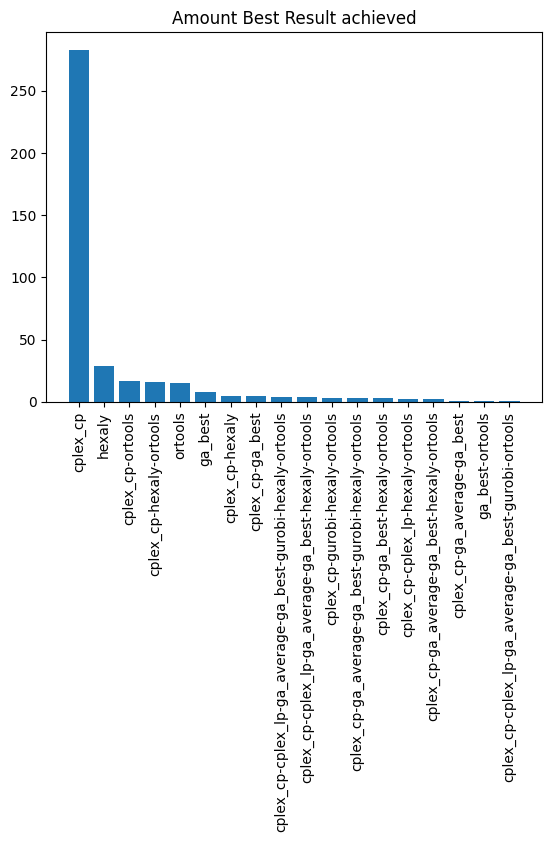

In [13]:
import matplotlib.pyplot as plt

plt.title('Amount Best Result achieved')
plt.bar([x[0] for x in comb_as_tuple if x[1] > 0 and x[0] != ''], [x[1] for x in comb_as_tuple if x[1] > 0 and x[0] != ''])
plt.xticks(rotation=90)
plt.show()

In [14]:
one_best_characteristics = dict()
some_best_characteristics = dict()
collected_best_characteristics = dict()
for instance in instances_with_one_best:
    for solver in best_solvers[instance]:
        if solver not in one_best_characteristics:
            one_best_characteristics[solver] = dict()
            one_best_characteristics[solver]['n_operations'] = []
            one_best_characteristics[solver]['flexibility'] = []
            one_best_characteristics[solver]['duration_variety'] = []
            one_best_characteristics[solver]['n_machines'] = []
        if solver not in collected_best_characteristics:
            collected_best_characteristics[solver] = dict()
            collected_best_characteristics[solver]['n_operations'] = []
            collected_best_characteristics[solver]['flexibility'] = []
            collected_best_characteristics[solver]['duration_variety'] = []
            collected_best_characteristics[solver]['n_machines'] = []
        one_best_characteristics[solver]['n_operations'].append(benchmark_data[instance]['n_operations'])
        one_best_characteristics[solver]['flexibility'].append(benchmark_data[instance]['flexibility'])
        one_best_characteristics[solver]['duration_variety'].append(benchmark_data[instance]['duration_variety'])
        one_best_characteristics[solver]['n_machines'].append(benchmark_data[instance]['n_machines'])
        collected_best_characteristics[solver]['n_operations'].append(benchmark_data[instance]['n_operations'])
        collected_best_characteristics[solver]['flexibility'].append(benchmark_data[instance]['flexibility'])
        collected_best_characteristics[solver]['duration_variety'].append(benchmark_data[instance]['duration_variety'])
        collected_best_characteristics[solver]['n_machines'].append(benchmark_data[instance]['n_machines'])
for instance in instances_with_some_best:
    for solver in best_solvers[instance]:
        if solver not in some_best_characteristics:
            some_best_characteristics[solver] = dict()
            some_best_characteristics[solver]['n_operations'] = []
            some_best_characteristics[solver]['flexibility'] = []
            some_best_characteristics[solver]['duration_variety'] = []
            some_best_characteristics[solver]['n_machines'] = []
        if solver not in collected_best_characteristics:
            collected_best_characteristics[solver] = dict()
            collected_best_characteristics[solver]['n_operations'] = []
            collected_best_characteristics[solver]['flexibility'] = []
            collected_best_characteristics[solver]['duration_variety'] = []
            collected_best_characteristics[solver]['n_machines'] = []
        some_best_characteristics[solver]['n_operations'].append(benchmark_data[instance]['n_operations'])
        some_best_characteristics[solver]['flexibility'].append(benchmark_data[instance]['flexibility'])
        some_best_characteristics[solver]['duration_variety'].append(benchmark_data[instance]['duration_variety'])
        some_best_characteristics[solver]['n_machines'].append(benchmark_data[instance]['n_machines'])
        collected_best_characteristics[solver]['n_operations'].append(benchmark_data[instance]['n_operations'])
        collected_best_characteristics[solver]['flexibility'].append(benchmark_data[instance]['flexibility'])
        collected_best_characteristics[solver]['duration_variety'].append(benchmark_data[instance]['duration_variety'])
        collected_best_characteristics[solver]['n_machines'].append(benchmark_data[instance]['n_machines'])

In [15]:
import statistics
def get_stats(data, solver):
    result = dict()
    if solver in data:
        result['count'] = len(data[solver]['n_operations'])
        result['operations_mean'] = statistics.mean(data[solver]['n_operations'])
        result['operations_stdv'] = statistics.stdev(data[solver]['n_operations'])
        result['flexibility_mean'] = statistics.mean(data[solver]['flexibility'])
        result['flexibility_stdv'] = statistics.stdev(data[solver]['flexibility'])
        result['duration_variety_mean'] = statistics.mean(data[solver]['duration_variety'])
        result['duration_variety_stdv'] = statistics.stdev(data[solver]['duration_variety'])
        result['machines_mean'] = statistics.mean(data[solver]['n_machines'])
        result['machines_stdv'] = statistics.stdev(data[solver]['n_machines'])
    return result

stats_data = dict()
for solver in collected_best_characteristics.keys():
    if solver not in stats_data:
        stats_data[solver] = dict()
    if solver in one_best_characteristics:
        stats_data[solver]['one_best'] = get_stats(one_best_characteristics, solver)
    if solver in some_best_characteristics:
        stats_data[solver]['some_best'] = get_stats(some_best_characteristics, solver)
    if solver in collected_best_characteristics:
        stats_data[solver]['collected_best'] = get_stats(collected_best_characteristics, solver)


In [23]:
def to_table_rows(data):
    table = ''
    for key in data:
        row = []
        if key == 'one_best':
            name = 'Single Best'
        elif key == 'some_best':
            name = 'Shared Best'
        else:
            name = 'Combined'
        row.append(name)
        row.append('{:.4f}'.format(data[key]['count']))
        row.append('{:.4f}'.format(data[key]['machines_mean']))
        row.append('{:.4f}'.format(data[key]['machines_stdv']))
        row.append('{:.4f}'.format(data[key]['operations_mean']))
        row.append('{:.4f}'.format(data[key]['operations_stdv']))
        row.append('{:.4f}'.format(data[key]['flexibility_mean']))
        row.append('{:.4f}'.format(data[key]['flexibility_stdv']))
        row.append('{:.4f}'.format(data[key]['duration_variety_mean']))
        row.append('{:.4f}'.format(data[key]['duration_variety_stdv']))
        table += ' & '.join(row)[:-1] + '\\'
    return table

In [24]:
to_table_rows(stats_data['cplex_cp'])

'Single Best & 283.0000 & 14.1413 & 12.5521 & 175.9647 & 112.4890 & 0.2751 & 0.1489 & 0.5515 & 0.769\\Shared Best & 62.0000 & 9.0968 & 10.8548 & 64.3226 & 52.9753 & 0.3818 & 0.2549 & 1.2659 & 1.135\\Combined & 345.0000 & 13.2348 & 12.4022 & 155.9014 & 112.7542 & 0.2943 & 0.1772 & 0.6799 & 0.888\\'

In [25]:
to_table_rows(stats_data['ga_best'])

'Single Best & 8.0000 & 54.3750 & 15.9099 & 217.5000 & 192.4095 & 0.2979 & 0.0504 & 0.0183 & 0.014\\Shared Best & 20.0000 & 13.3000 & 17.9827 & 51.2500 & 76.3923 & 0.5725 & 0.3147 & 1.2959 & 1.211\\Combined & 28.0000 & 25.0357 & 25.5002 & 98.7500 & 139.8368 & 0.4940 & 0.2937 & 0.9309 & 1.174\\'

In [26]:
to_table_rows(stats_data['ortools'])

'Single Best & 15.0000 & 7.4667 & 2.4456 & 78.0000 & 29.3331 & 0.1975 & 0.1134 & 1.6282 & 1.506\\Shared Best & 52.0000 & 6.2692 & 3.0040 & 56.3462 & 39.8216 & 0.3920 & 0.2554 & 1.4513 & 1.140\\Combined & 67.0000 & 6.5373 & 2.9146 & 61.1940 & 38.6081 & 0.3485 & 0.2445 & 1.4909 & 1.221\\'

In [27]:
to_table_rows(stats_data['hexaly'])

'Single Best & 29.0000 & 10.1034 & 1.9151 & 116.7586 & 52.2478 & 0.1322 & 0.0876 & 1.0510 & 1.062\\Shared Best & 38.0000 & 6.3421 & 3.2572 & 57.6842 & 52.8466 & 0.3886 & 0.2779 & 1.4358 & 1.124\\Combined & 67.0000 & 7.9701 & 3.3211 & 83.2537 & 59.9453 & 0.2776 & 0.2509 & 1.2693 & 1.106\\'

In [28]:
to_table_rows(stats_data['cplex_lp'])

'Shared Best & 7.0000 & 4.2857 & 2.2147 & 19.1429 & 17.2668 & 0.5388 & 0.3409 & 1.8079 & 0.912\\Combined & 7.0000 & 4.2857 & 2.2147 & 19.1429 & 17.2668 & 0.5388 & 0.3409 & 1.8079 & 0.912\\'

In [29]:
to_table_rows(stats_data['gurobi'])

'Shared Best & 7.0000 & 6.5714 & 2.1492 & 30.0000 & 21.7025 & 0.5914 & 0.2848 & 1.3214 & 1.471\\Combined & 7.0000 & 6.5714 & 2.1492 & 30.0000 & 21.7025 & 0.5914 & 0.2848 & 1.3214 & 1.471\\'

In [30]:
row= ['a', 'b', 'c']
x= '&'.join(row) + '\n'

In [31]:
print(x)

a&b&c



In [32]:
test = dict({'a': 1, 'b': 2, 'c': 3})
len(test)

3

In [33]:
l = ['a', 'b', 'c']
'-'.join(l)

'a-b-c'

In [34]:
import itertools
combs = []
str_combs = []
for i in range(1, len(l)+1):
    els = [list(x) for x in itertools.combinations(l, i)]
    for el in els:
        str_combs.append('-'.join(el))
    combs.append(els)


In [35]:
combs

[[['a'], ['b'], ['c']],
 [['a', 'b'], ['a', 'c'], ['b', 'c']],
 [['a', 'b', 'c']]]

In [36]:
str_combs

['a', 'b', 'c', 'a-b', 'a-c', 'b-c', 'a-b-c']